# Aula 9 - KNN

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de classificação: o KNN, que é a sigla de **k nearest neighbours**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada. A cada observação que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, emordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a  habitual abordagem de tentativa e erro!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Vamos ao nosso exemplo prático?

In [1]:
# importe as principais bibliotecas

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de cancer de mama (os mesmo discutidos no notebook de inferência), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo classificador entre câncer maligno e benigno.

In [2]:
# leia a base de "../datasets/breast_cancer.csv"

df = pd.read_csv("../datasets/breast_cancer.csv")

In [3]:
# dê uma olhada no info, describe, etc

df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [4]:
# drope a coluna de id

df = df.drop(columns="id")

Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

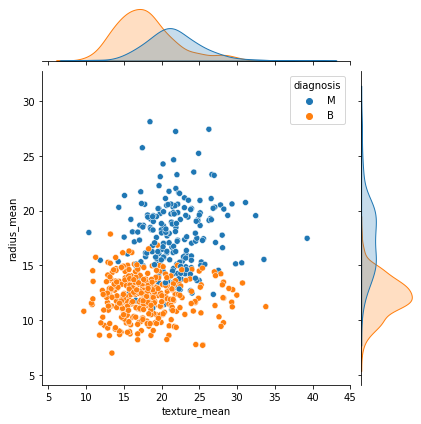

In [5]:
# visualize a relação entre as colnas x='texture_mean' e y='radius_mean'
# sempre adicione o hue!!

sns.jointplot(data=df, x='texture_mean', y='radius_mean', hue="diagnosis")

Uma pergunta é muitíssimo importante:

In [6]:
# os dados são balanceados com relação ao target?

df["diagnosis"].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


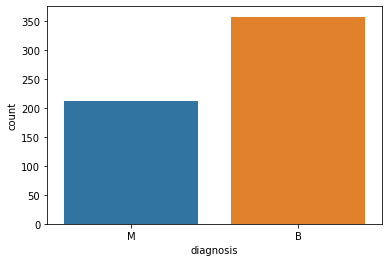

In [7]:
sns.countplot(df["diagnosis"])

Há um leve desbalanceamento: há mais dados acerca de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema.

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [37]:
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [8]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [9]:
y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [10]:
# 1) Importe a classe do estimador que se deseja treinar

from sklearn.neighbors import KNeighborsClassifier

In [11]:
# 2) Instancie a classe do estimador, escolhendo os hiperparâmetros desejados 
# parâmetros importantes: n_neighbors e metric
# por enquanto, fixe apenas k = 5

estimador = KNeighborsClassifier()

In [12]:
# 3) Separe os dados em dados de treino e dados de teste
# use o train-test split com atenção ao parâmetro stratify!!

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [13]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [14]:
y_train.value_counts(normalize=True)

B    0.626374
M    0.373626
Name: diagnosis, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

B    0.631579
M    0.368421
Name: diagnosis, dtype: float64

In [16]:
# 4) Treine o modelo, usando os dados de treino. 

modelo = estimador.fit(X_train, y_train)

In [17]:
# 5) Use o modelo treinado para fazer previsões usando os dados de teste 

y_pred = modelo.predict(X_test)

In [18]:
# 6) Avalie a performance do modelo com base nas previsões acima
# matriz de confusão e classification report


from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 9 33]]

Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.89      0.99      0.93        72
           M       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [19]:
# redefinir pra poder alterar novamente
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# normalizando as features com o standardscaler

from sklearn.preprocessing import StandardScaler 

# instanciando a classe
scaler = StandardScaler()

# transformando as features de treino com o método fit_transform()
X_train = scaler.fit_transform(X_train)

# fitando o modelo novamente
estimador = KNeighborsClassifier()
modelo = estimador.fit(X_train, y_train)

# transformando também as features de teste com o mesmo scaler! PASSO IMPORTANTE!
# importante: use apenas o método transform()
X_test = scaler.transform(X_test)

# faça as predições com as features de teste transformadas
y_pred = modelo.predict(X_test)

# avalie o modelo
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]

Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [20]:
# dados normalizados com a média em zero
X_train

array([[ 0.51855873,  0.89182579,  0.4246317 , ..., -0.23574392,
         0.05456632,  0.02183673],
       [-0.51636409, -1.63971029, -0.54134872, ..., -0.32320788,
        -0.13757624, -0.90440164],
       [-0.36811839,  0.45551496, -0.38824993, ..., -0.89082504,
        -0.675893  , -0.14401559],
       ...,
       [-0.32616206,  1.33280304, -0.38905998, ..., -0.84289958,
        -0.96490082, -1.16888375],
       [ 0.00948859,  0.25952507,  0.00786279, ...,  0.27571059,
        -0.60284707, -0.30545988],
       [ 0.80945595,  0.36918608,  0.79320285, ...,  1.00657384,
        -0.46151907, -0.44817001]])

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [21]:
# redefinir pra poder alterar novamente
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# normalizando as features com o standardscaler

from sklearn.preprocessing import MinMaxScaler

# instanciando a classe
scaler = MinMaxScaler()

# transformando as features de treino com o método fit_transform()
X_train = scaler.fit_transform(X_train)

# fitando o modelo novamente
estimador = KNeighborsClassifier()
modelo = estimador.fit(X_train, y_train)

# transformando também as features de teste com o mesmo scaler! PASSO IMPORTANTE!
# importante: use apenas o método transform()
X_test = scaler.transform(X_test)

# faça as predições com as features de teste transformadas
y_pred = modelo.predict(X_test)

# avalie o modelo
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]

Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [22]:
# dados transformados entre 0 e 1
X_train

array([[0.42780065, 0.45755834, 0.40709004, ..., 0.34278351, 0.27261975,
        0.19336219],
       [0.25268588, 0.0906324 , 0.24227766, ..., 0.32271478, 0.24876799,
        0.08310376],
       [0.27776989, 0.39431857, 0.26839887, ..., 0.19247423, 0.18194362,
        0.17361931],
       ...,
       [0.28486914, 0.52147447, 0.26826066, ..., 0.20347079, 0.14606742,
        0.0516201 ],
       [0.34166312, 0.3659114 , 0.33598231, ..., 0.46013746, 0.19101124,
        0.15440115],
       [0.4770221 , 0.38180588, 0.46997443, ..., 0.62783505, 0.2085551 ,
        0.13741309]])

**importante:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!

____
____
____

## 2) Ferramentas especiais

Vamos agora ver algumas ferramentas especiais do sklearn que nos ajudam no desenvolvimento de modelos!

______

### Pipeline

O [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) é uma estrutura que o sklearn proporciona a fim de garantir que possamos em uma única estrutura passar **o estimador e o transformador**. Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/compose.html#pipeline). 

Vamos ver a seguir como esta estrutura funciona:

In [23]:
# redefinir pra poder alterar novamente
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# importando a classe de pipeline
from sklearn.pipeline import Pipeline

# o que queremos utilizar para construir o modelo
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# instanciando a classe
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

# fitamos o pipeline: ambas as operações são aplicadas!
# note que o objeto que é fitado é o pipeline!
pipe.fit(X_train, y_train)

# fazendo predições 
# o pipeline garante que o scaler não usará dados de teste!!
y_pred = pipe.predict(X_test)

# testando o modelo
# exatamente o mesmo que acima!
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]

Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



______

### Gridsearch

O [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) é uma estrutura que o sklearn proporciona para que seja feita **a busca exaustiva de hiperparâmetros de um modelo**.

Na prática, o que o gridsearch faz é **treinar diversos modelos com diferentes combinações de hiperparâmetros**, de modo a manter o melhor deles como o modelo final, tudo automaticamente! Tudo o que precisamos fazer é indicar quais os hiperparâmetros que queremos procurar: a **grade**!

É muito comum também passarmos o **pipeline** como argumento do gridsearch!

Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). 

Vamos ver a seguir como esta estrutura funciona:

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': np.arange(1, 20),
              'knn__weights':['uniform', 'distance'], 
              'knn__metric':["euclidean", 'manhattan', "chebyshev"]}

# os quatro principais principais parâmetros!
grid = GridSearchCV(pipe, param_grid, scoring="f1_weighted", cv=5)

# treine o objeto da grade com os dados de treino]
grid.fit(X_train, y_train)

# faça previsões (COM O MELHOR MODELO) a partir as features de teste
y_pred = grid.predict(X_test)

# avalie o MELHOR MODELO
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Matriz de confusão do modelo nos dados de teste:

[[72  0]
 [ 4 38]]

Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



O Gridsearch avalia o melhor modelo segundo a métrica que passamos em `scoring`. [Clique aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para ver as métricas disponíveis por padrão.

Mas o GS vai além: ele não calcula a métrica uma única vez, mas sim **várias vezes**, conforme especificado pelo parâmetro `cv`. No fim, o melhor modelo é o que tem o melhor scoring **médio** entre as vezes que é calculado.

O "cv" quer dizer **Cross Validation**, o método mais seguro de realizar um treinamento e avaliação de um modelo:

<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600> 

Naturalmente, cada um dos folds são feitos de modo **aleatório**, garantindo assim uma avaliação justa do modelo, **e que faça uso de toda a base de dados!!**

O GS treinado tem diversos atributos super úteis e interessantes! Vamos dar uma olhada neles:

`.best_estimator_`: retorna quais as escolhas do Pipeline que produziram o melhor modelo. No que diz respeito ao modelo, temos exatamente quais os parâmetros escolhidos!

In [28]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

`.best_params_`: retorna os parâmetros testados na grade que produziram o melhor modelo.

In [29]:
grid.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

`.best_score_`: retorna a **média cross-validada da métrica de interesse** do melhor modelo. Como esse é o valor médio construído usando CV, este é estatisticamente o valor mais realístico a ser atribuído à performance do modelo!

In [30]:
grid.best_score_

0.9689744866505638

`.cv_results_`: diversas informações do processo feito pelo GS

In [35]:
grid.cv_results_

{'mean_fit_time': array([0.01701455, 0.01180868, 0.01350861, 0.01480994, 0.01369905,
        0.01501036, 0.02671151, 0.0422359 , 0.04056487, 0.03692379,
        0.03391943, 0.01964869, 0.01706696, 0.01290984, 0.01010847,
        0.01420217, 0.01323051, 0.01501193, 0.01552534, 0.01071272,
        0.01270971, 0.01963754, 0.03102584, 0.0202189 , 0.01528406,
        0.00940757, 0.0150641 , 0.01308689, 0.0144743 , 0.01370921,
        0.0125102 , 0.04722319, 0.01556087, 0.01290908, 0.01022296,
        0.01051035, 0.01282415, 0.01352839, 0.01057549, 0.0130703 ,
        0.01277447, 0.01371913, 0.01368489, 0.01030512, 0.01576648,
        0.01613564, 0.01486464, 0.01060581, 0.01731634, 0.01234159,
        0.01351013, 0.01421051, 0.01641254, 0.01601195, 0.01480927,
        0.01160803, 0.01811256, 0.02101488, 0.01791368, 0.00993681,
        0.01601129, 0.01291456, 0.01721177, 0.01951332, 0.01638851,
        0.01351156, 0.01610556, 0.01437116, 0.01521015, 0.01350918,
        0.01357236, 0.01050401,